## Testing Raw plot

In [82]:
## Testing an optimization on a small set of files
## It includes the optimization by cycle:detection+subtraction
##

## Main loop to extract in e2e the DBSCAN parameters.
## The list of votable is selected directly from the directory

using  PyCall
using DataFrames, Query
using CSV, Glob, Dates
using Statistics, Random
using Printf
using MultivariateStats, StatsBase

import PyPlot

rootdir =  ENV["GAIA_ROOT"]

push!(LOAD_PATH,"$rootdir/run/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
votdir  = "$rootdir/e2e_products/votable.edr3.2021"
plotdir = "$rootdir/products/plot-TEST"
ocdir   = "$rootdir/products/oc-TEST"


## Maximum random votable for testing
MAX_VOTABLE = 1


1

In [ ]:
function readlist_votable(filelist::String)
    vot = CSV.read(filelist)
    return(vot)
end

function _getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data, [0,2000])
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.0,5.0,1.0]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
 end


## to check if done and record
## check and updt if votname analyzed. If not done return false
function _updt_votcompleted(fileres, votname , cycletot=1, flag= 0 , onlycheck=true)
    let
        if  onlycheck
            if !isfile(fileres)
                return(0, false)
            else
                res = CSV.File(fileres, delim=";") |> DataFrame
                if votname in res.votname
                    x = @from i in res begin
                        @where i.votname == votname
                        @select i
                        @collect DataFrame
                    end
                    return(x, true)
                else
                    return(0, false)
                end
            end
            ## UPDTE
        else
            if !isfile(fileres)
                res = DataFrame(votname=votname, cycle=cycletot, flag=flag)
                CSV.write(fileres,res,delim=';')
                println("## $fileres created...")
                return(res,true)
            else
                res= CSV.File(fileres, delim=";") |> DataFrame
                newrow = DataFrame(votname=votname,cycle=cycletot, flag=flag)
                append!(res,newrow)
                CSV.write(fileres,res,delim=';')
                return(res,true)
            end
        end
    end
end
## check for blacklist
##
function _read_blacklist(blackname)
    if isfile(blackname)
        df= CSV.read(blackname, DataFrame, delim=";")
        blacklist= df.votname
    else
        blacklist= [""]
    end

    return(blacklist)
end


In [ ]:
function _plot_rawdata(plotdir, voname, indx, sc::GaiaClustering.SCproperties2, df::GaiaClustering.Df, ijump=100,
    showplot = true , extra= 0, cmap = "gist_stern")
    patch= pyimport("matplotlib.patches")

    nsize= size(df.data)
    nstar= nsize[2]
    iter= 1:ijump:nstar
    
    println("### Cluster plot is centered in Y,Z...")
    PyPlot.plt.rcParams["font.size"]= 25

    PyPlot.plt.figure(figsize=(13.0,12.0))
    PyPlot.plt.subplot(3, 3, 1)

    xx = df.data[2,1iter] 
    yy = df.data[3,iter] 
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[2,indx] 
    yy = df.data[3,indx] 
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 )    
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)

    PyPlot.plt.subplot(3, 3, 2 )
    xx = df.data[1,iter]
    yy = df.data[3,iter] 
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[1,indx] 
    yy = df.data[3,indx] 
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 )     
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)

    PyPlot.plt.subplot(3, 3, 4 )
    xx = df.data[2,iter] .- mean(df.data[2,indx])
    yy = df.data[1,iter]
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[2,indx] 
    yy = df.data[1,indx] 
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 )     
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)

    PyPlot.plt.subplot(3, 3, 3 )
    xx = df.data[1,iter]
    yy = df.raw[13,iter]
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[1,indx]
    yy = df.raw[13,indx]  
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 )     
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)

    ## text to display
    axt= PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    
    if extra != 0
        text =[]
        v1= "$(extra.votname[1])"
        txt = "Votable : $v1" ; push!(text,txt)
        v = nstar ; txt = "N stars in the field  : $v" ; push!(text,txt)
        v1= "$(extra.cycle[1])"
        txt = "Cycle : $v1" ; push!(text,txt)
        v1= @sprintf("%3.3f",extra.qc[1])
        txt = "Qc : $v1" ; push!(text,txt)
        v1= @sprintf("%3.3f",extra.score_cycle[1])
        txt = "Score : $v1" ; push!(text,txt)
        v1= @sprintf("%3.3f",sc.offdeg)
        txt = "Offset : $v1 (degree)" ; push!(text,txt)
        v1= @sprintf("%3.3f",sc.edgratg)
        txt = "Edge ratio(g) : $v1 " ; push!(text,txt)
        v1= @sprintf("%3.3f",sc.edgratm)
        txt = "Edge ratio(m) : $v1 " ; push!(text,txt)
        show_text(-0.01,-0.1, text , 1.1 )
        rec= patch.Rectangle((-0.07, -0.15), 1.2, 1.15, color="salmon", alpha= 0.4, clip_on=false)
        axt.add_artist(rec)
    end

    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")
    xx = df.data[7,iter]
    yy = -df.data[6,iter]
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[7,indx]
    yy = -df.data[6,indx]  
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 ) 
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)

    PyPlot.plt.subplot(3, 3, 8 )
    xx = df.data[4,iter]
    yy = df.data[5,iter]
    PyPlot.plt.scatter(xx, yy , s = 0.1 )
    xx = df.data[4,indx]
    yy = df.data[5,indx]  
    PyPlot.plt.scatter(xx, yy , s = 1, c="r", alpha=0.5 ) 
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)


    figname = plotdir*"/"*voname*".raw.png"
    PyPlot.plt.savefig(figname)

    if showplot PyPlot.plt.show() end
end

In [ ]:
function _cycle_extraction(df::GaiaClustering.Df, dfcart::GaiaClustering.Df, m::GaiaClustering.meta)
    
        println("############### cycle_extraction #########")

        votname= m.votname
        cyclerun= true ; cycle= 1 ; FLAG= 0

        sclist= [] ; mcmclist= [] ; perflist= [] ; chainlist= []

        println("##")
        while cyclerun
            FLAG= -1
            tstart= now()
            println("###############")
            println("## starting cycle $cycle ...")
            @printf("## starting time: %s \n",tstart)
            ## extraction one cycle.. MCMC optimization
            mc , iter, FLAGmcmc= abc_mcmc_dbscan_full2(dfcart, m)
            println("## ABC/MCMC flag: $FLAGmcmc")
            nchain= length(mc.qc)
            println("## $iter iterations performed...")
            println("## $nchain chains")

            if FLAGmcmc== -1 || nchain > m.minchainreached
                println("## optimization completed..")
                println("## analyzing solutions...")
                plot_dbscanfull_mcmc(m.plotdir, "$votname.$cycle", mc , false)

                ## get the cluster and plot it
                println("## extracting the cluster using DBSCAN/WEIGHTING with:")
                res= extraction_mcmc(mc, m.votname)
                eps= res.epsm[1]
                min_nei= trunc(Int,res.mneim[1] + 0.5)
                min_cl= trunc(Int,res.mclm[1] + 0.5)
                w3d= res.w3dm[1]
                wvel= res.wvelm[1]
                whrd= res.whrdm[1]

                mres = GaiaClustering.modelfull(eps,min_nei,min_cl,w3d,wvel,whrd)
                dfcartnorm = getDfcartnorm(dfcart, mres)
                labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
                labelmax , nmax, qc = find_cluster_label2(labels, df, dfcart, m)
                println("## label $labelmax written to oc...")
                export_df("$votname.$cycle", m.ocdir, df , dfcart, labels , labelmax)

                edgeratio1, edgeratio2= edge_ratio(dfcart, labels[labelmax])
                scproperties = get_properties_SC2(labels[labelmax] , df, dfcart)
                scdf= convertStruct2Df(scproperties)
                insertcols!(scdf, 1, :votname => votname)
                s=size(scdf)
                insertcols!(scdf, 2, :cycle => cycle)
                insertcols!(res, 2,  :cycle => cycle)
                push!(sclist, scdf)
                push!(mcmclist, res)

                ## create DF chain
                dfchain= create_DFchain(mc, votname, cycle)
                push!(chainlist,dfchain)

                println("###")
                println("### label solution: $labelmax")
                println("### Offdeg: $(scproperties.offdeg)")
                println("### Edge ratio: $(scproperties.edgratm)")
                println("### N stars: $nmax")
                println("### Qc: $qc")
                println("###")

                k= score_cycle(qc, nmax, nchain, iter)
                @printf("## score cycle %d: %3.3f \n",cycle, k)

                extraplot= DataFrame(cycle=cycle, score_cycle=k, qc=qc, votname=votname)

                plot_cluster2(m.plotdir, "$votname.$cycle", labels[labelmax], scproperties,
                    dfcart , false, extraplot)
                
                jump= 100  # how many stars to jump in the plot
                _plot_rawdata(m.plotdir, "$votname.$cycle", labels[labelmax], scproperties,
                    dfcart , jump, true, extraplot)

                println("###")
                println("### subtracting BEST solution from Df...")
                dfnew, dfcartnew= remove_stars(df, dfcart, labels[labelmax])
                df= dfnew
                dfcart= dfcartnew

                ########################### STOP conditions #########
                FLAG= 0
                if nmax < m.minstarstop
                    FLAG= FLAG | (1<<0)
                    println("### extraction stopped at cycle $cycle")
                    println("### nmax too low...")
                    cyclerun= false
                end
                if cycle == m.cyclemax
                    FLAG= FLAG | (1<<1)
                    println("### extraction stopped at cycle $cycle")
                    println("### cyclemax reached...")
                    cyclerun= false
                end
                if qc < m.qcminstop
                    FLAG= FLAG | (1<<2)
                    println("### extraction stopped at cycle $cycle")
                    println("### Qc too low...")
                    cyclerun= false
                end
                if w3d/wvel < m.wratiominstop || wvel/w3d < m.wratiominstop
                    FLAG= FLAG | (1<<3)
                    println("### extraction stopped at cycle $cycle")
                    println("### weight ratio too low...")
                    cyclerun= false
                end
                if FLAGmcmc == 3 && nchain > m.minchainreached
                    FLAG= FLAG | (1<<4)
                    println("## extraction stopped at cycle $cycle")
                    println("## chain iteration not performed completely but sufficient to keep...")
                    cyclerun= false
                end
                #####################################################
                ## Time
                tend= now()
                duration= Dates.value(tend-tstart) / (1000*1)
                nstar= size(df.raw)[2]
                timeperiterstar= duration / (iter*nstar)
                timeperchainstar= duration / (nchain*nstar)
                @printf("## \n")
                @printf("## Time: \n")
                @printf("## duration per cycle %3.3f sec \n", duration)
                @printf("## duration per iteration*star %3.3e sec \n", timeperiterstar)
                @printf("## duration per chain*star %3.3e sec \n", timeperchainstar)
                @printf("##\n")

                ## log the results of performances
                dfout= DataFrame(votname=votname, cycle=cycle, nstar=nstar, qc=qc, nmax=nmax, nchain=nchain, iter=iter,
                scorecycle=k, duration=duration, timeperiterstar=timeperiterstar ,
                timeperchainstar= timeperchainstar )
                push!(perflist, dfout)

                cycle += 1
            else
                println("## nothing found, stopped...")
                FLAG= 0
                cyclerun= false
            end
        end
        if cycle >= 2
            save_cycle(sclist, mcmclist, perflist, chainlist, m)
        end
        return(cycle-1, FLAG)
    
end

In [ ]:
function main(filelist, metafile)
    
        wd= pwd() ; nfile= size(filelist)[1] ; totalTime= 0.
        println("## Starting main loop using optimization with cycles...")
        println("## It can be very long but will be resumed to the last reduced file.")
        println("## Working directory: $wd")
        println("## $nfile files to analyze...")

        m= read_params(metafile, false)
        m.plotdir= plotdir
        m.ocdir= ocdir
        fileres= "$(m.prefile).done.csv"

        # read a possible votname blacklist
        blackname= "blacklist-test.csv"
        blacklist= _read_blacklist(blackname)
        println("## blacklist read...")
        for i in 1:nfile
            votname = filelist[i]
            res, votfound= _updt_votcompleted(fileres, votname, 0, 0, true)

            ## test blacklist
            if votname in blacklist
                println("##")
                println("## $votname in blacklist...")
                println("##")
                votfound= true
            end

        
            if !votfound
                tstart= now()
                println("###########################")
                println("## Starting with $votname")
                println("## Starting at $tstart")

                df , dfcart , dfcartnorm = _getdata(votdir*"/"*votname)
                m.votname= votname
                cycle, flag= _cycle_extraction(df, dfcart, m)
                res,  votfound= _updt_votcompleted(fileres, votname , cycle, flag, false)

                tend= now()
                println("## Ending at $tend")
                println("## number of cycle: $cycle , flag:$flag ")
                println("##########################")
                println("##")

                duration= Dates.value(tend-tstart) / (1000*3600)
                totalTime += duration
                meanTime= totalTime / i
                ETA= meanTime * (nfile-i) / 24
                nleft= nfile-i
                ETAstr= @sprintf("%3.3f", ETA) ; durationstr= @sprintf("%3.3f", duration)
                @printf("## %s \n",specialstr("Duration: $durationstr hours","YELLOW"))
                @printf("## %s \n",specialstr("ETA: $ETAstr days","YELLOW"))
                @printf("## %s \n",specialstr("Votable done: $votname","YELLOW"))
                @printf("## %s \n",specialstr("Files analyzed: $i","YELLOW"))
                @printf("## %s \n",specialstr("Files to go: $nleft","YELLOW"))
                println("##\n##")

            end
        end
    
    println("## Main loop done.")
end

In [ ]:
header_extract()

cd(votdir)
votlist= glob("NGC*.vot")
cd(wdir)

rng = MersenneTwister()
shuffle!(rng, votlist)

main(votlist[1:MAX_VOTABLE],"configAll.ext.test")
PyPlot.plt.show()

# Testing PCA to discard bad extractions

By computing PCA on extracted OC and filtering on the PC1 or PC2 variance ratio

In [135]:
function compute_PCA(oclist)
    
    for oc in oclist
        print("## $oc \n")
        
        df= CSV.File(joinpath(ocdir,oc)) |> DataFrame
        s=size(df)
        data= zeros(8,s[1])
        data[1,:]= df.X  .- mean(df.X)
        data[2,:]= df.Y
        data[3,:]= df.Z
        data[4,:]= df.vl
        data[5,:]= df.vb
        data[6,:]= df.gbar
        data[7,:]= df.gbar .- df.rp
        data[8,:]= df.bp .- df.gbar 
        
        # d=Array(data')
        dt= StatsBase.fit(ZScoreTransform, data)
        d2= StatsBase.transform(dt, data)
        M = fit(PCA, d2)
        
        println(M)
        totvar= tvar(M) 
        pvs= principalvars(M)
        ratioac= accumulate(+, pvs ./ totvar)
        println(ratioac)
        restxt= @sprintf(" PC1: %3.1f , PC2: %3.1f , PC3: %3.1f", 100*ratioac[1], 100*ratioac[2], 100*ratioac[3])
        
        Yt = MultivariateStats.transform(M, d2)
        pc1= Yt[1,:]
        pc2= Yt[2,:]
        pc3= Yt[3,:]
        
        dct= Dict("color"=> "black", "fontsize"=> 11)
        PyPlot.plt.figure(figsize=(7.0,5.0))
        
        PyPlot.plt.title(oc)
        # PyPlot.plt.subplot(1, 2, 1)
        #PyPlot.plt.scatter(pc1, pc2 , s = 1, c="r", alpha=0.5 )
        
        PyPlot.plt.subplot(1, 1, 1)
        PyPlot.plt.text(-2,-2,restxt, dct)
        PyPlot.plt.xlabel("PC1")
        PyPlot.plt.xlabel("PC2")       
        PyPlot.plt.scatter(pc1, pc2 , s = 1, c="b", alpha=0.5 )         
        
        PyPlot.plt.show()
    end
    
end


compute_PCA (generic function with 1 method)

## FSR 0612-2.0deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9957549101394674)
[0.37753654005803977, 0.5456928590585561, 0.6929221663652281, 0.8129622575174548, 0.909792907757324, 0.9872262748549816, 0.9957549101394675]
## FSR 1435-2.3deg.2.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9946029670593072)
[0.41291544564552324, 0.6289842833539939, 0.7746033476973821, 0.9004069590829685, 0.9709519284582497, 0.9855748421052423, 0.9946029670593073]
## NGC 7429-2.0deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9913757634884197)
[0.35137046809599787, 0.606673515454986, 0.7563673703491305, 0.8809813122090175, 0.9414249414579539, 0.9732496333974497, 0.9913757634884198]
## Stock 4-2.1deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.998114074605965)
[0.35014091584906804, 0.559460511657607, 0.7143454022000097, 0.8116799678209015, 0.9001253531812883, 0.9704976139403514, 0.998114074605965]
## NGC 2509-2.0deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalr

PCA(indim = 8, outdim = 7, principalratio = 0.995290340216665)
[0.35350061408658434, 0.5606883767668567, 0.71203477974054, 0.8439213722578005, 0.9314163510336411, 0.9714214404025466, 0.9952903402166648]
## FSR 1435-2.3deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9968170883287507)
[0.36681601433836925, 0.5998386409910927, 0.7293039496953627, 0.8552327190777054, 0.942213340286743, 0.9845026848297334, 0.9968170883287506]
## Ruprecht 76-2.0deg.2.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9943095291447072)
[0.3681554451957291, 0.5583253842094872, 0.7012298463452709, 0.8257550883442873, 0.9140259583923789, 0.9733107612305903, 0.9943095291447069]
## Alessi 8-2.6deg.1.oc.csv 
PCA(indim = 8, outdim = 8, principalratio = 0.9999999999999999)
[0.2236492850997466, 0.4000318598728685, 0.5626430776551699, 0.6882127081257147, 0.7942072082769909, 0.8883158023570472, 0.9531962772622786, 1.0000000000000002]
## NGC 2527-3.4deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio =

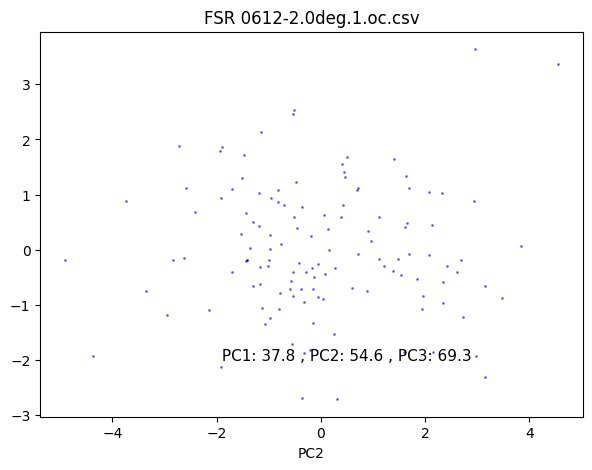

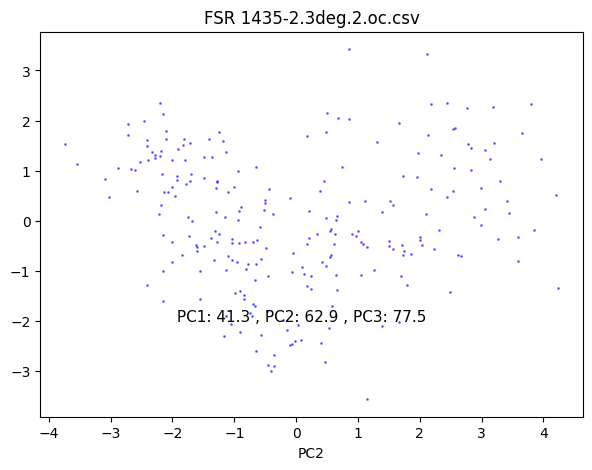

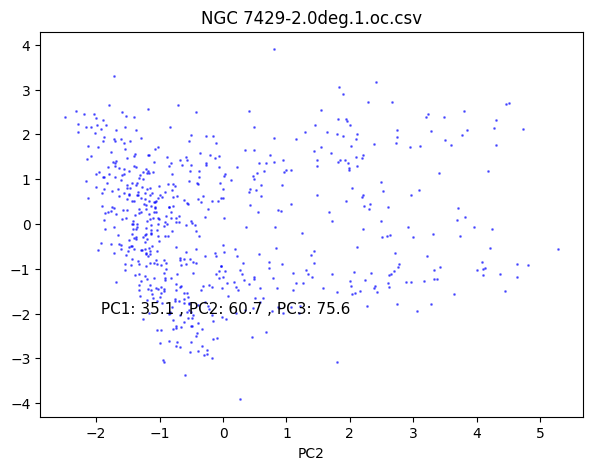

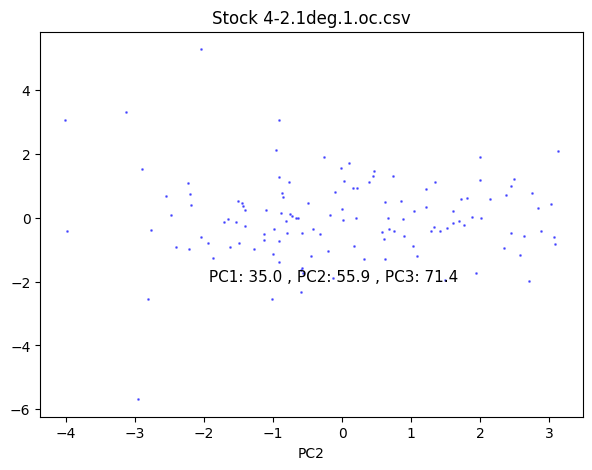

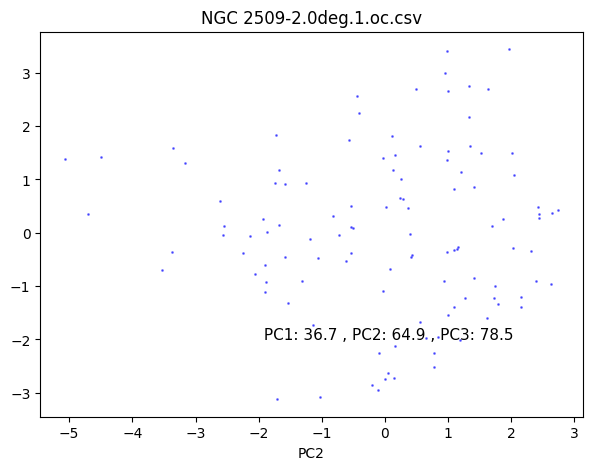

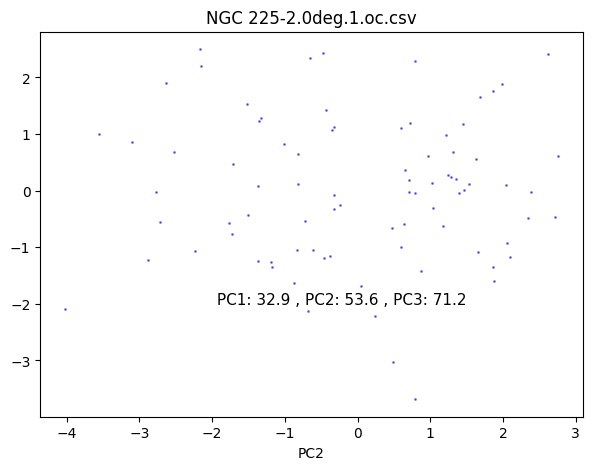

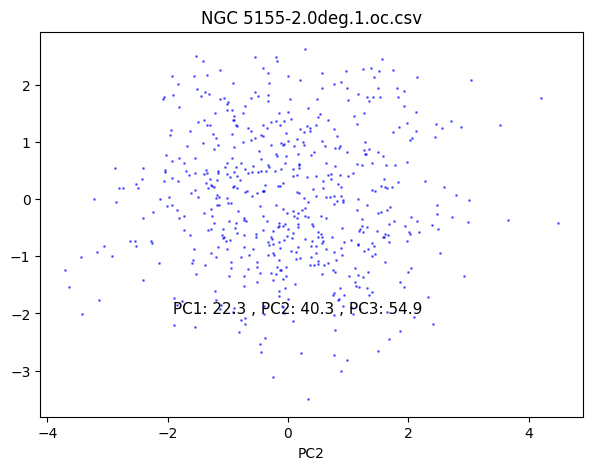

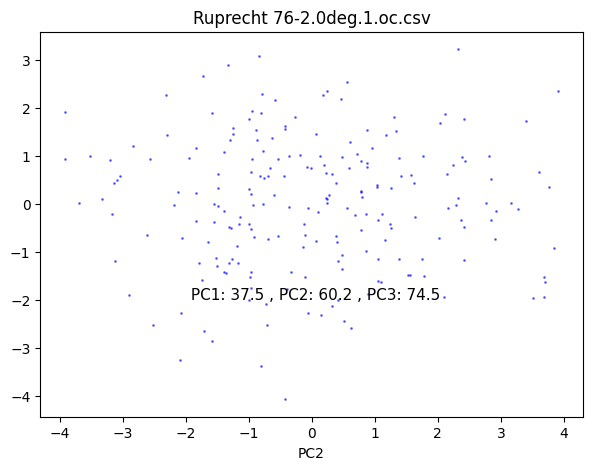

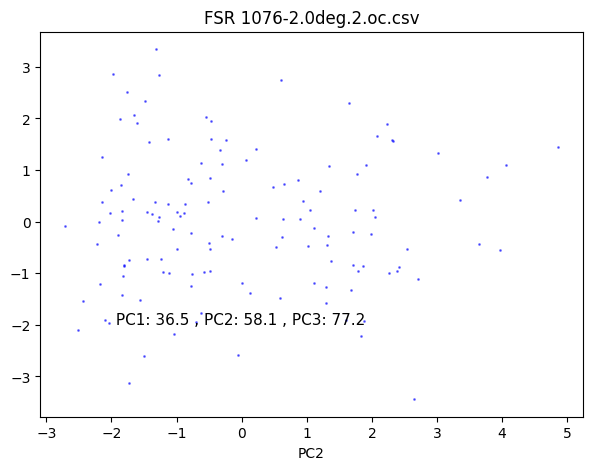

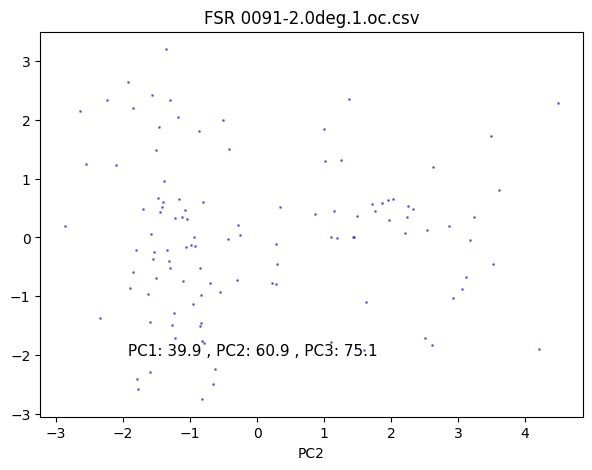

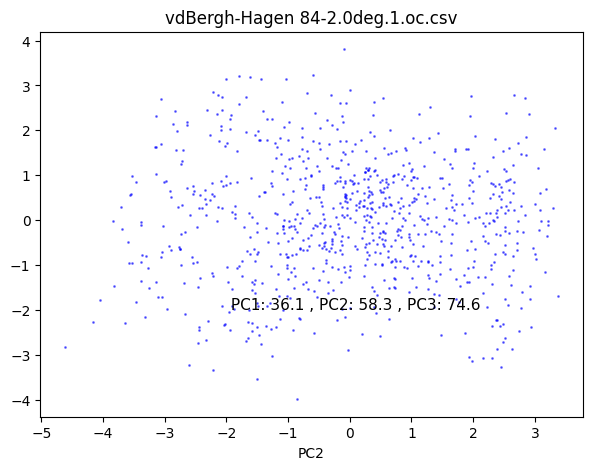

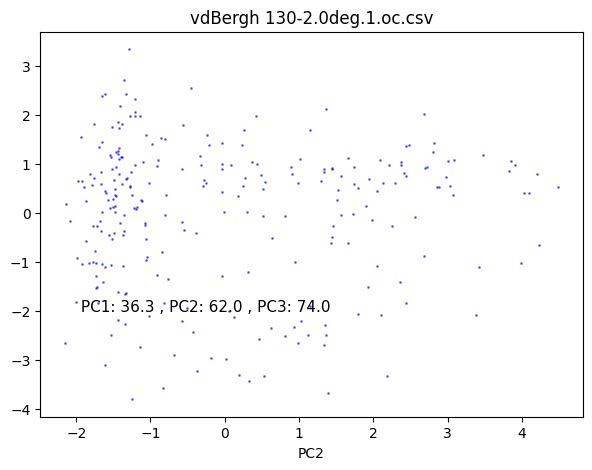

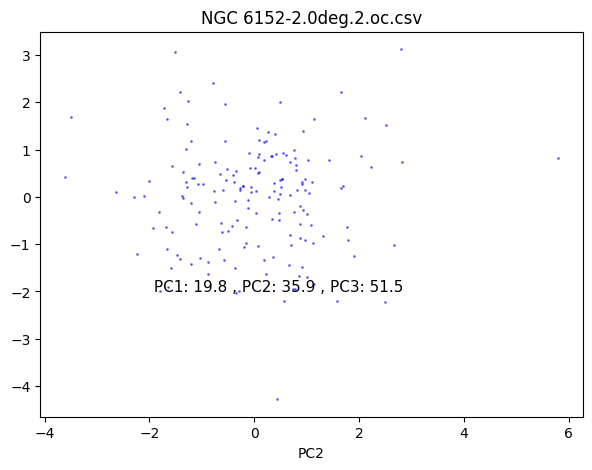

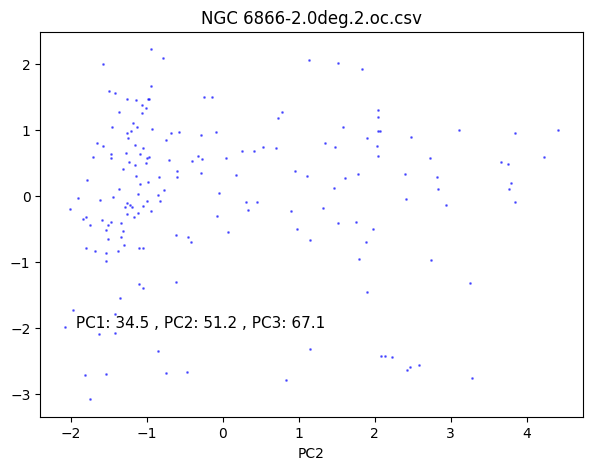

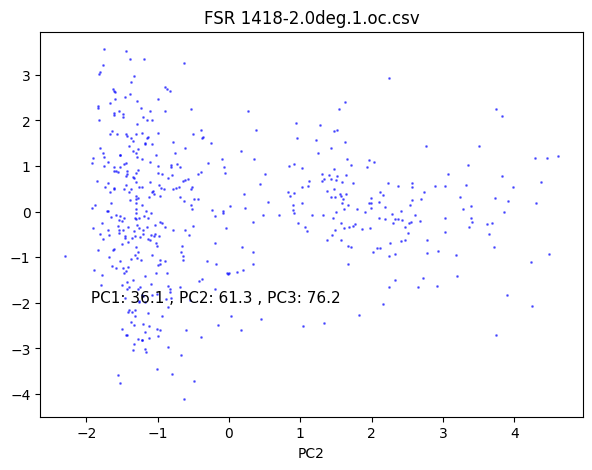

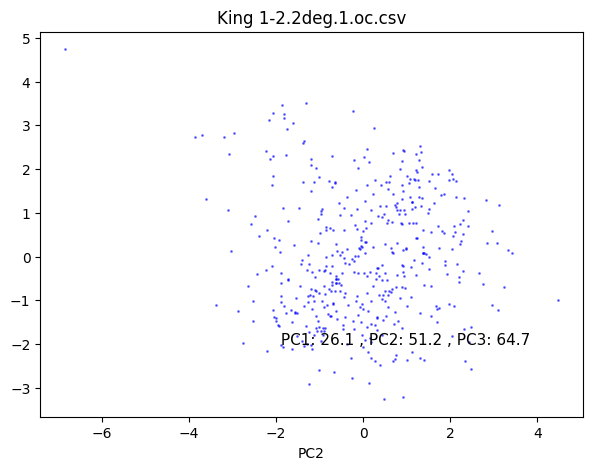

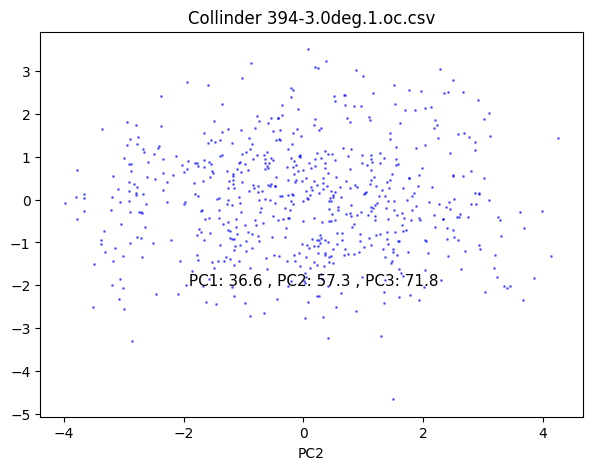

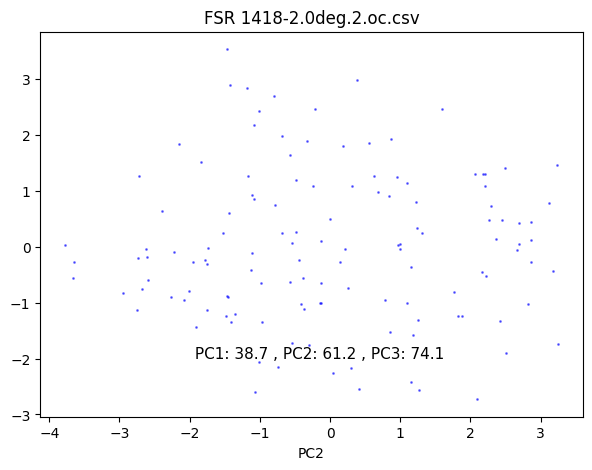

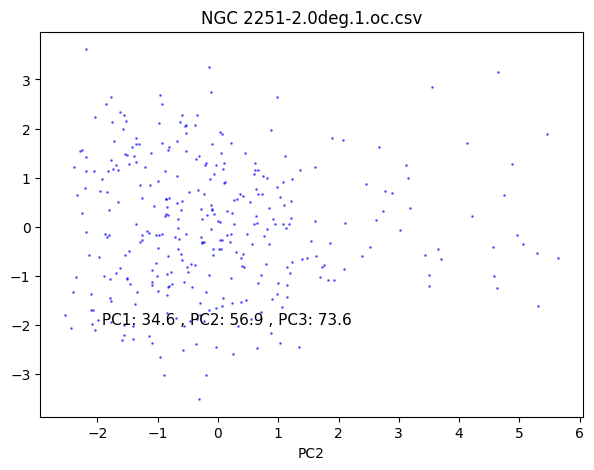

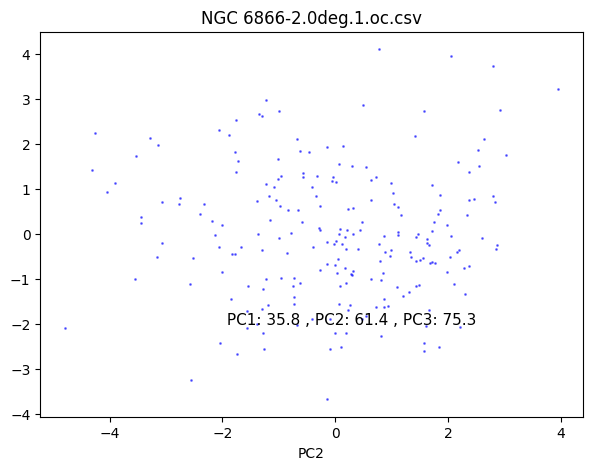

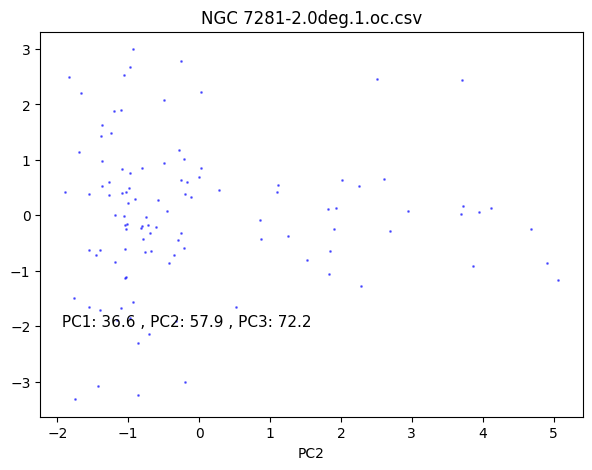

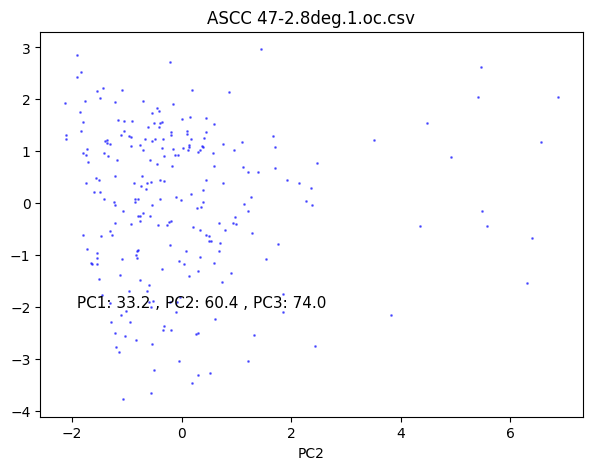

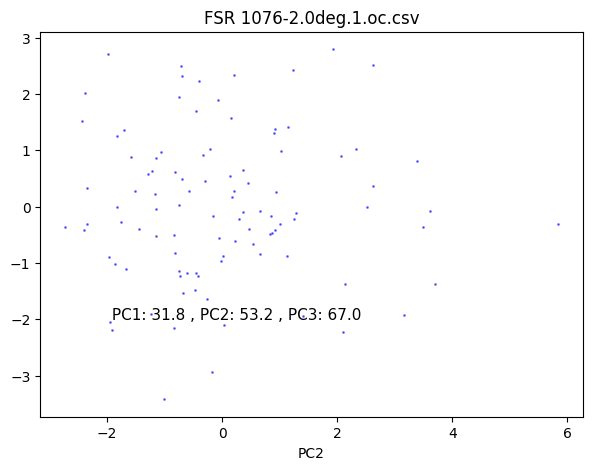

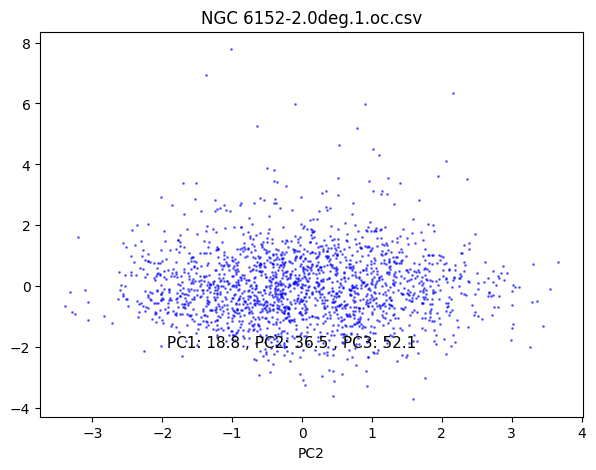

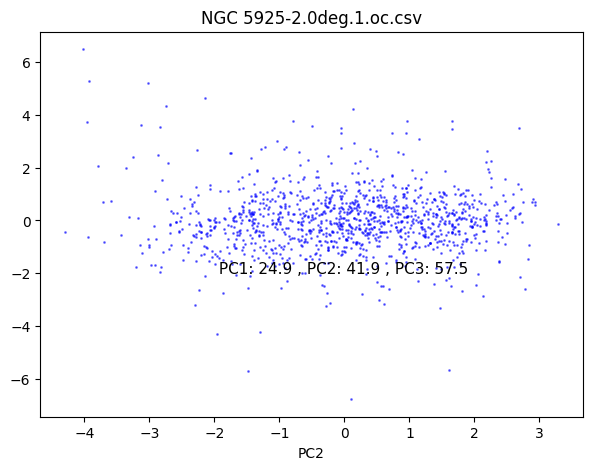

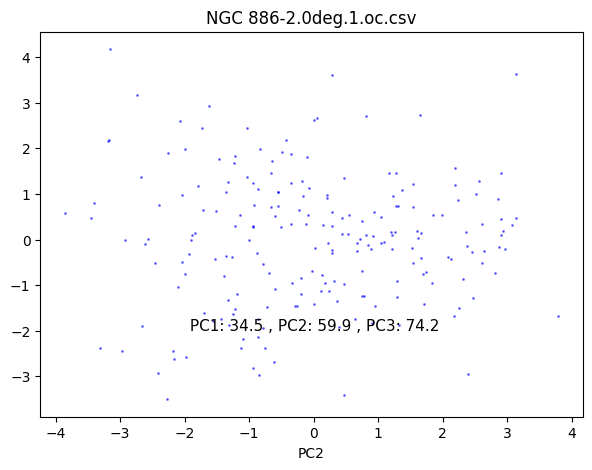

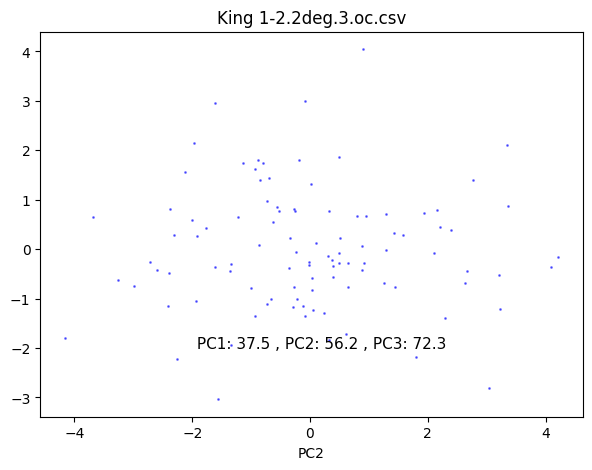

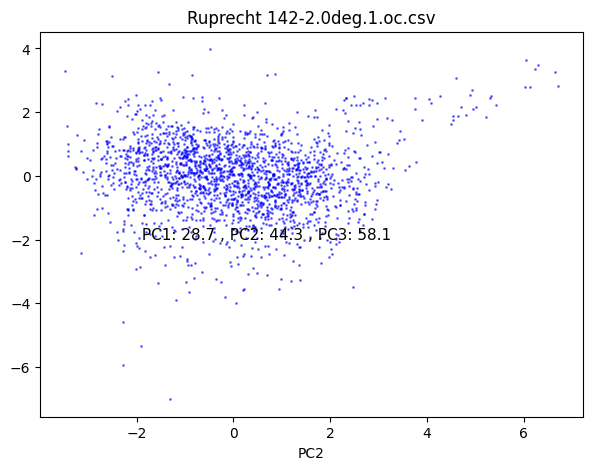

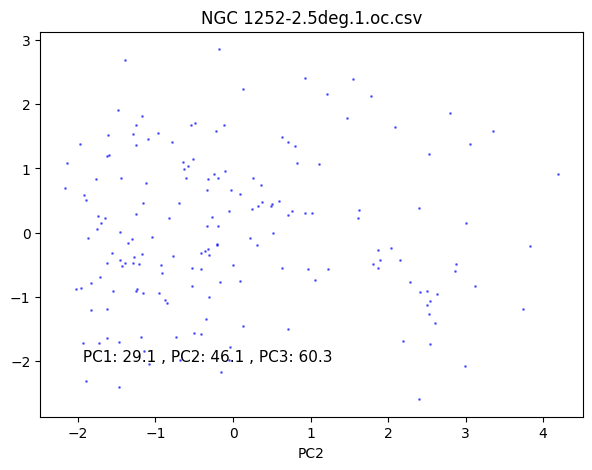

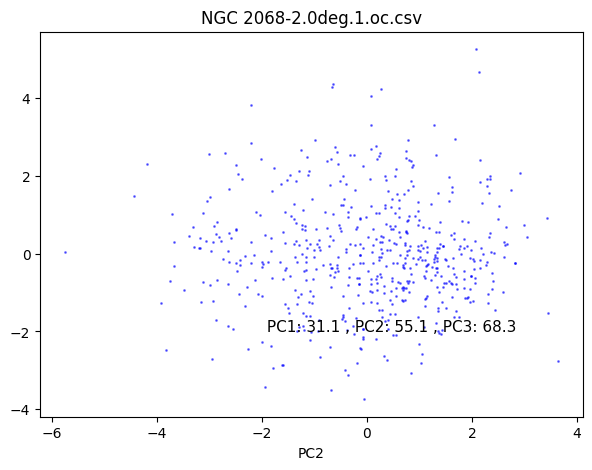

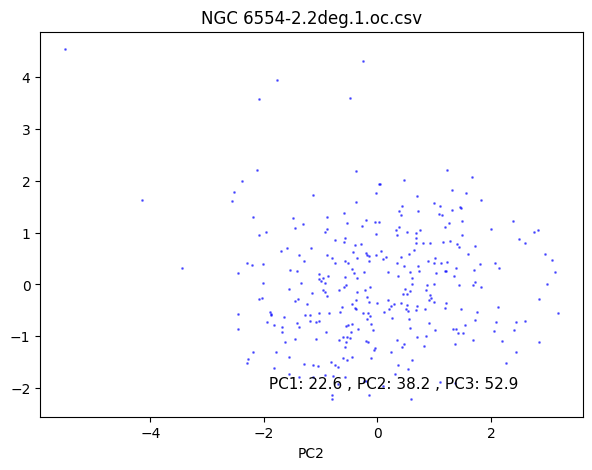

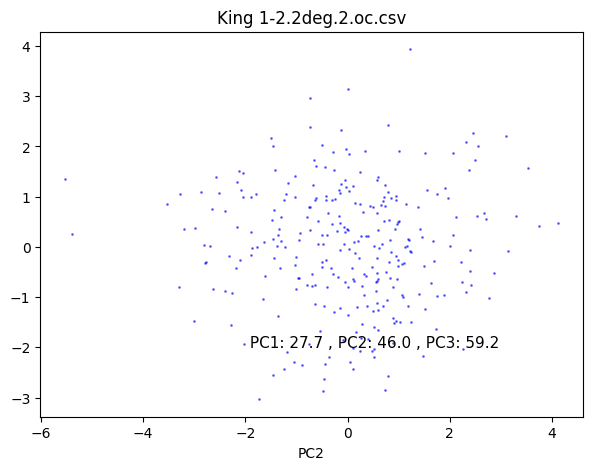

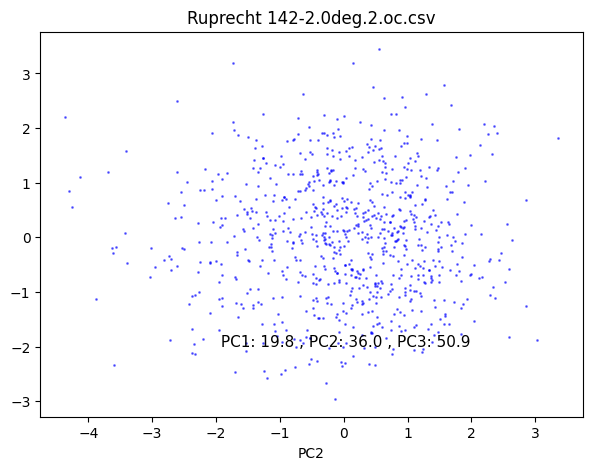

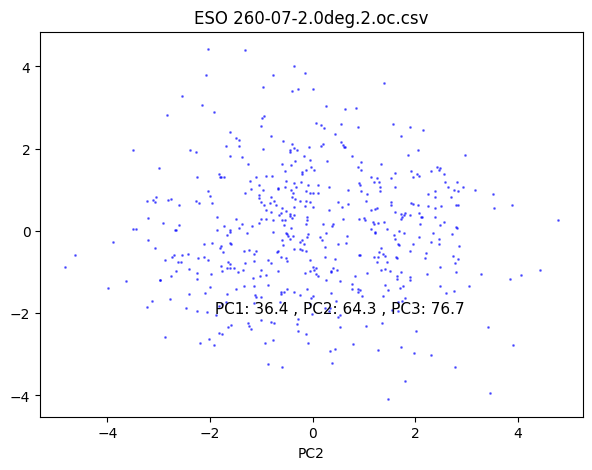

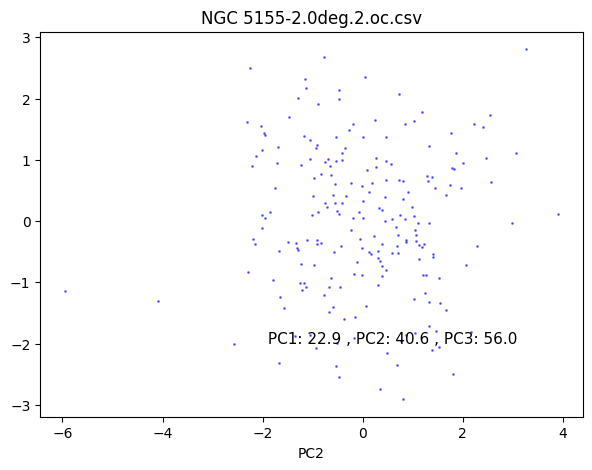

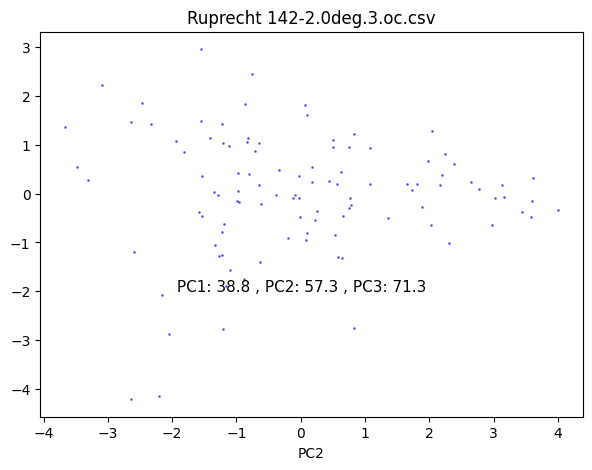

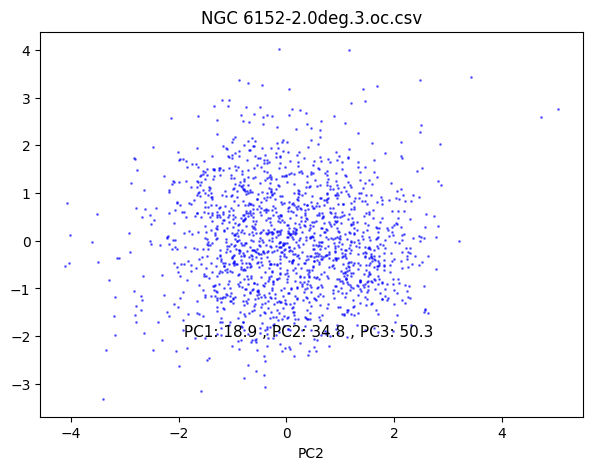

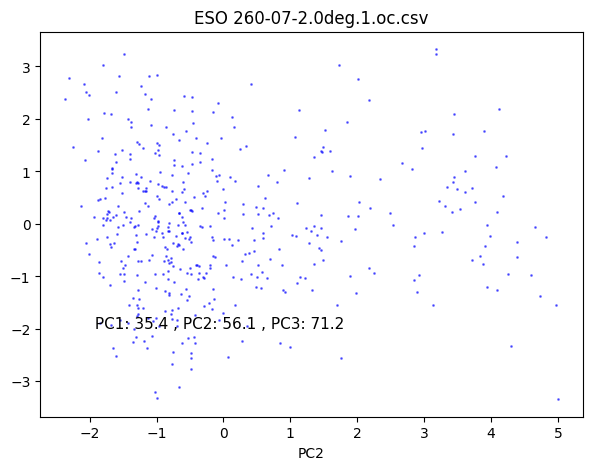

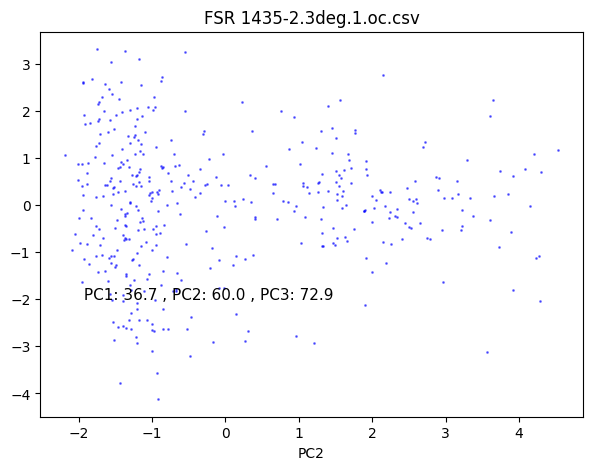

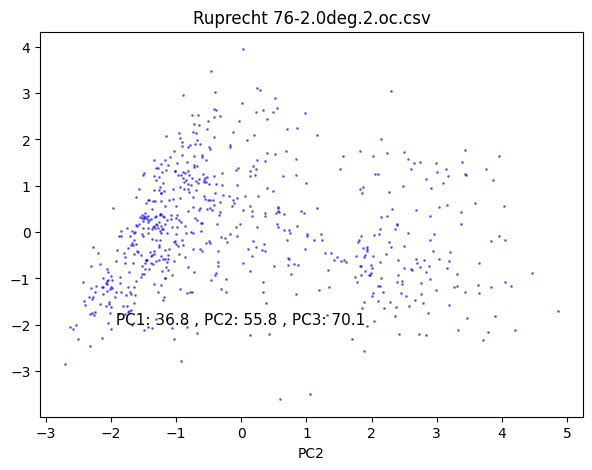

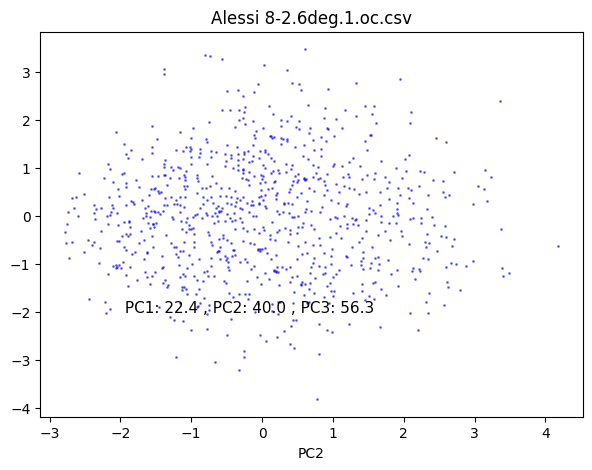

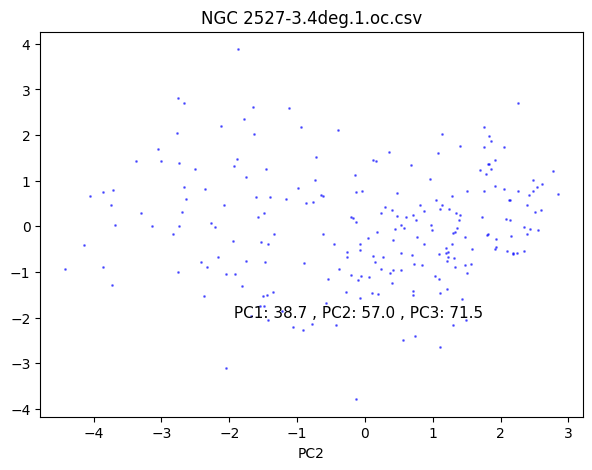

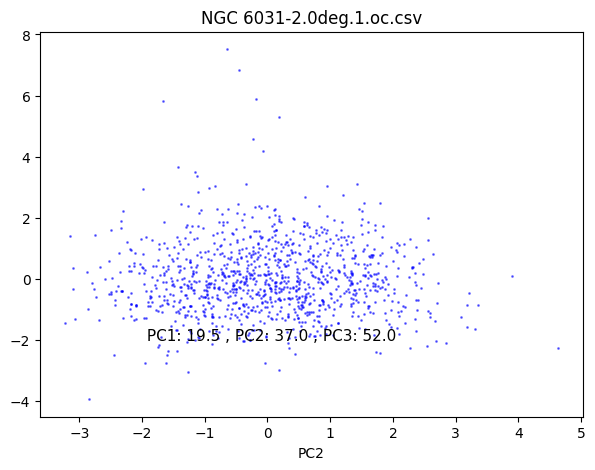

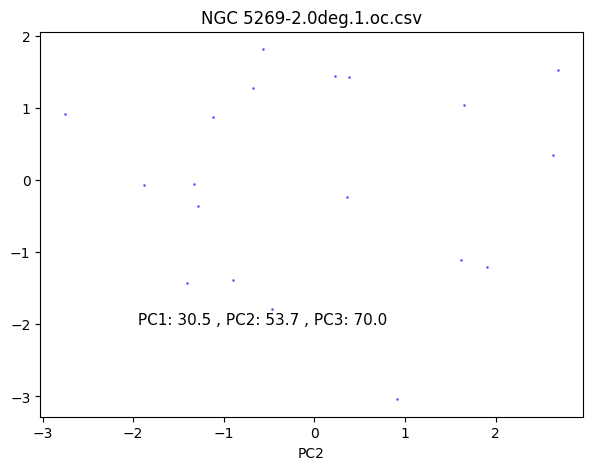

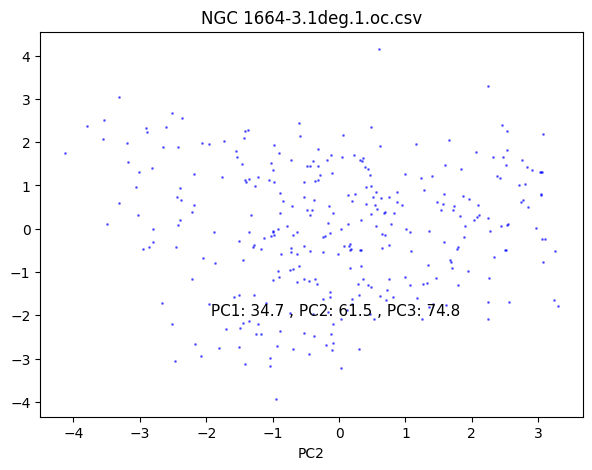

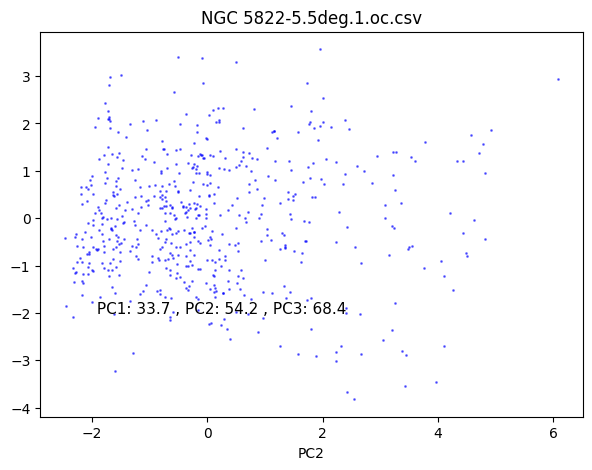

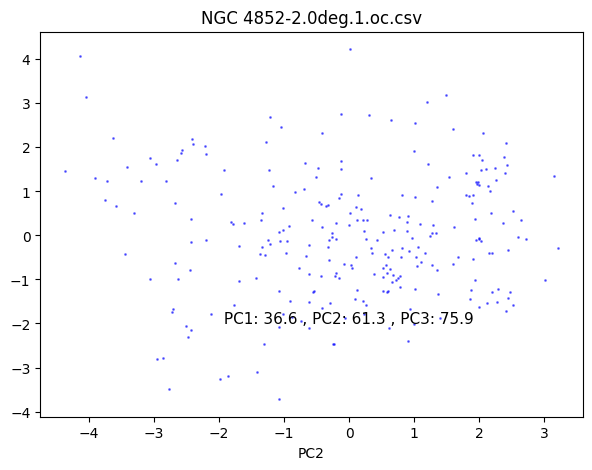

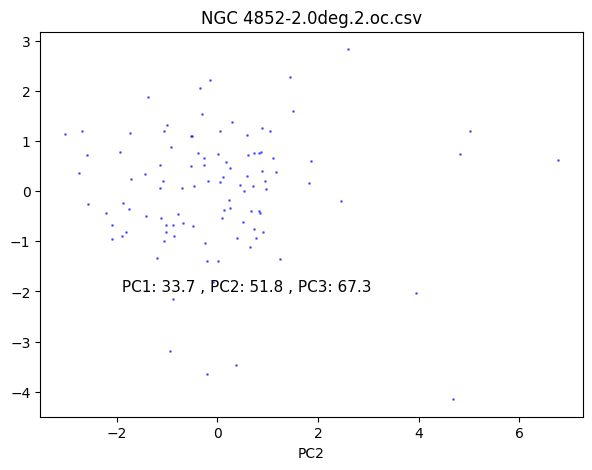

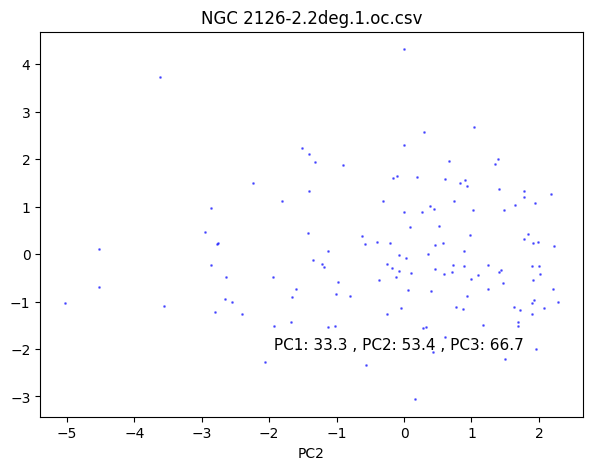

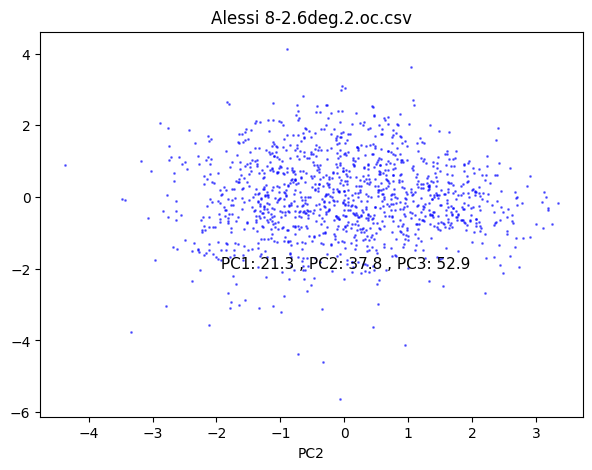

PCA(indim = 8, outdim = 8, principalratio = 1.0000000000000002)
[0.3470260737693035, 0.6151105581727411, 0.7480700338575593, 0.8689888919315385, 0.9470437315293795, 0.9717680843583834, 0.9895360573735896, 1.0000000000000002]
## NGC 5822-5.5deg.1.oc.csv 
PCA(indim = 8, outdim = 8, principalratio = 1.0)
[0.33661824533879564, 0.5421613405724626, 0.6838432205914041, 0.809905833736253, 0.9156980545838932, 0.9576813006949481, 0.989695506504421, 1.0]
## NGC 4852-2.0deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9959535147869819)
[0.3659291758635623, 0.6127567146248105, 0.7591416140393932, 0.8700825020488024, 0.9567316164927302, 0.9866524471265122, 0.9959535147869821]
## NGC 4852-2.0deg.2.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.9902303614161654)
[0.33744145898490063, 0.5184538133241673, 0.6727124180792681, 0.7791885685411936, 0.8723625979100783, 0.9534187464297814, 0.9902303614161654]
## NGC 2126-2.2deg.1.oc.csv 
PCA(indim = 8, outdim = 7, principalratio = 0.99855230

In [138]:
MAX_OC= 50

cd(ocdir)
oclist= glob("*.csv")
cd(wdir)

rng = MersenneTwister()
shuffle!(rng, oclist)

compute_PCA(oclist[1:MAX_OC])
